# First example of causal inference

Goal of this notebook: 

In [1]:
%%capture
from synth_data_generator import generate_linear_data 
%load_ext iventure.magics
%matplotlib inline

## 1. Synthetic Data

The following graphical model is used to generate N datapoints: 

![title](img/causal_example.png)

using the following linear generative system:

$ a := \eta_a$ where $\eta_a \sim \mathcal{N}(0,2)$

$ b := \eta_b$ where $\eta_b \sim \mathcal{N}(0,2)$

$ c := \eta_c$ where $\eta_c \sim \mathcal{N}(0,2)$

$ d := 3c + e_d$ where $\eta_d \sim \mathcal{N}(0,1)$

$ e := \eta_e$ where $\eta_e \sim \mathcal{N}(0,2)$

$ f := \eta_f$ where $\eta_f \sim \mathcal{N}(0,2)$

$ g := 2e + + 2f + e_g$ where $\eta_g \sim \mathcal{N}(0,1)$



In [2]:
N = 100

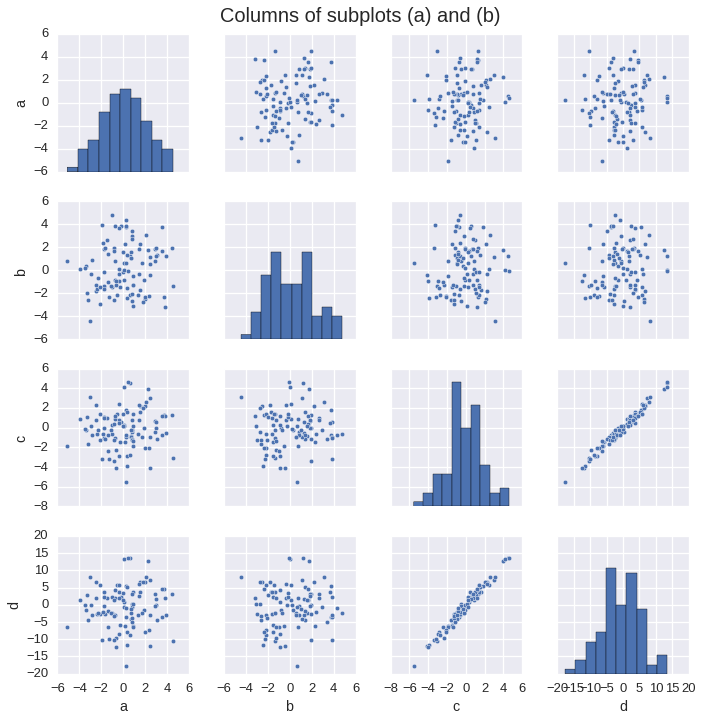

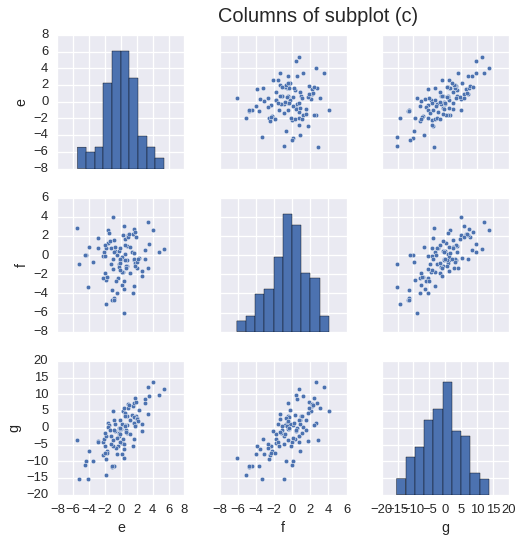

In [3]:
generate_linear_data(N)

## 2. BDB - Population and Analysis 

In [4]:
%bayesdb -j bdb_files/causal_linear.bdb

u'Loaded: bdb_files/causal_linear.bdb'

## (a) two independent nodes

In [24]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [25]:
%%venturescript
define list_of_nodes = ["a", "b"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [26]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));



assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

In [27]:
%%venturescript
mh(default, all, 10);

In [28]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

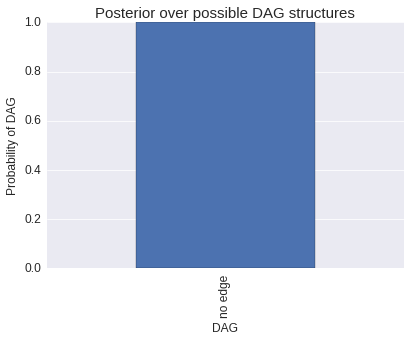

In [29]:
%%venturescript
plot_posterior_dags(posterior_samples);

## (b) two dependent nodes

In [11]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [12]:
%%venturescript
define list_of_nodes = ["c", "d"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [13]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};

assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv((i) -> {
        mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

In [14]:
%%venturescript
mh(default, all, 10);

In [15]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(20)));

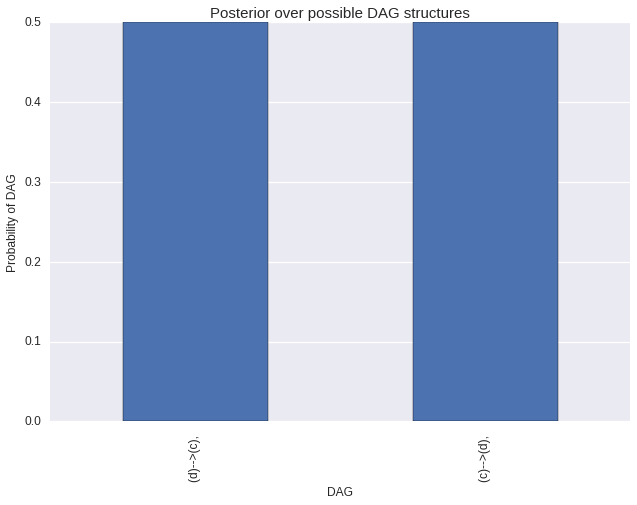

In [16]:
%%venturescript
plot_posterior_dags(posterior_samples);

## (c) V structure

In [17]:
%ripl --seed 0 --plugins   causal_inference_plugin.py 

Set seed of a new VentureScript RIPL to 0.00.
Loading plugin: causal_inference_plugin.py


In [18]:
%%venturescript
define list_of_nodes = ["e", "f", "g"];
define population = "causal_linear_population";
define metamodel = "causal_linear_cc";
define path_to_bdb_file = "bdb_files/causal_linear.bdb";
define list_of_cmi_queries = get_cmi_queries(list_of_nodes, population);

In [19]:
%%venturescript
list_of_cmi_queries[1]

'CREATE TABLE  mi_e_f AS\n            SIMULATE\n                MUTUAL INFORMATION OF e WITH f\n                USING 100 SAMPLES\n                AS mi FROM MODELS OF causal_linear_population;'

In [20]:
%%venturescript
assume number_nodes = size(${list_of_nodes});
assume get_causal_ordering = (list_of_nodes) -> {
    if(size(list_of_nodes)==1) {
        list_of_nodes}
    else {
        if(size(list_of_nodes)==2){// well, [1] + [2] is [3] whereas 
                                   // [1] + [2,3] shows the desired behaviour
                                   // namely [1,2,3]. Therefore, we need another
                                   // condition to catch this.
            if(flip()) {list_of_nodes} else {[list_of_nodes[1], list_of_nodes[0]]}}
        else {                  
            random_index ~ uniform_discrete(0, size(list_of_nodes));
            popped =  pop(list_of_nodes, random_index);
            [popped[0]] + get_causal_ordering(popped[1])}}
    
};



assume causal_ordering = get_causal_ordering(arange(number_nodes));

assume edge = mem((parent, child) -> {
   causal_ordering_parent = integer(find(causal_ordering, parent));
   causal_ordering_child = integer(find(causal_ordering, child));
   if (causal_ordering_parent >= causal_ordering_child){
            False
        }
   else {
            flip() 
        }});

assume DAG = mapv(
        (i) -> {mapv((j) -> {edge(real(i),real(j))}, arange(number_nodes))},
        arange(number_nodes));

assume observation_function = make_observation_function(
                              ${population},
                              ${metamodel},
                              ${path_to_bdb_file}
                              );

observe observation_function(DAG, ${list_of_nodes}) = list_of_cmi_queries;

In [21]:
%%venturescript
mh(default, all, 100);

In [22]:
%%venturescript
define posterior_samples = run(mapM((_)->{
    mh(default, all, 1);
    sample(dag_to_dot_notation(DAG, ${list_of_nodes}))
    }, arange(50)));

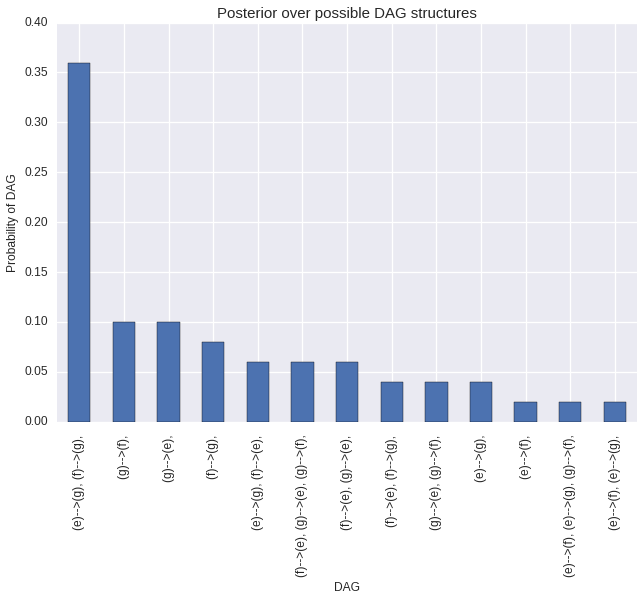

In [23]:
%%venturescript
plot_posterior_dags(posterior_samples);